In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import sys

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from ipywidgets import widgets, interactive
import plotly.figure_factory as ff
import plotly.graph_objs as go
from IPython.display import HTML
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from bs4 import BeautifulSoup
import time
from selenium.common.exceptions import StaleElementReferenceException
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

# Sentiment Analysis of Spotify's Top 50 of 2010

Now comes another interesting part of this project - incorporating lyrical sentiment analysis into how we view a song. We all have experience where the music can compound the lyrics and give it a powerful effect. For the time being, we will start with the most popular songs of the past decade - is it possible that this is something that makes these songs so popular? 

So we will start by taking the file that was made from running the other notebook (SpotifyAudioFeatures).

In [7]:
%run -i 'client_id_script.py'

In [66]:
tens_df = pd.read_csv('top2010s.csv')

However, because we are reading a csv, some of the columns that were once lists or numerical values are not strings... thus, we'll have to make some edits to change those back.

In [115]:
tens_df.head()

,Name,Artists,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,One Dance,"[Drake, WizKid, Kyla]",0.00776,https://api.spotify.com/v1/audio-analysis/1zi7...,0.792,173987,0.625,1zi7xx7UVEFkmKfv06H8x0,0.001880,1,0.3290,-5.609,1,0.0536,103.967,4,https://api.spotify.com/v1/tracks/1zi7xx7UVEFk...,audio_features,spotify:track:1zi7xx7UVEFkmKfv06H8x0,0.370
1,Lean On (feat. MØ & DJ Snake),"[Major Lazer, MØ, DJ Snake]",0.00346,https://api.spotify.com/v1/audio-analysis/1qE4...,0.723,176561,0.809,1qE47wUKG2juJwPoLqg4C9,0.001230,7,0.5650,-3.081,0,0.0625,98.007,4,https://api.spotify.com/v1/tracks/1qE47wUKG2ju...,audio_features,spotify:track:1qE47wUKG2juJwPoLqg4C9,0.274
2,Sunflower - Spider-Man: Into the Spider-Verse,"[Post Malone, Swae Lee]",0.53300,https://api.spotify.com/v1/audio-analysis/0RiR...,0.755,157560,0.522,0RiRZpuVRbi7oqRdSMwhQY,0.000000,2,0.0685,-4.368,1,0.0575,89.960,4,https://api.spotify.com/v1/tracks/0RiRZpuVRbi7...,audio_features,spotify:track:0RiRZpuVRbi7oqRdSMwhQY,0.925
3,Somebody That I Used To Know,"[Gotye, Kimbra]",0.54800,https://api.spotify.com/v1/audio-analysis/1qDr...,0.865,244885,0.521,1qDrWA6lyx8cLECdZE7TV7,0.000115,0,0.0989,-6.932,1,0.0371,129.059,4,https://api.spotify.com/v1/tracks/1qDrWA6lyx8c...,audio_features,spotify:track:1qDrWA6lyx8cLECdZE7TV7,0.748
4,Rolling in the Deep,[Adele],0.13100,https://api.spotify.com/v1/audio-analysis/1Ckv...,0.729,228293,0.756,1CkvWZme3pRgbzaxZnTl5X,0.000000,8,0.0527,-5.119,1,0.0294,104.945,4,https://api.spotify.com/v1/tracks/1CkvWZme3pRg...,audio_features,spotify:track:1CkvWZme3pRgbzaxZnTl5X,0.522


In [70]:
rsults = []
for i in range(len(tens_df)):
    result = [x.strip() for x in tens_df.iloc[i]["Artists"].replace("[", "").replace("]", "").replace("'", "").split(",")]
    rsults.append(result)
tens_df["Artists"] = rsults

In [117]:
to_change = ["acousticness", 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
            'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 
            'time_signature', 'valence']

for column in to_change:
    tens_df[column] = tens_df[column].astype(float)

For our sentiment analysis, we will be using a package called VADER (Valence Aware Dictionary and sEntiment Reasoner). It is specifically geared toward uncovering sentiment in social media. This may not be the perfect sentiment analysis package, but this could be used to compare to another sentiment analysis tool in the future.

In [9]:
analyser = SentimentIntensityAnalyzer()

In [10]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

For VADER, we can look at sentences (or even paragraphs) and see what proportion of the sentence is considered "positive", "negative", or "neutral" in sentiment. We will test this out with lyrics from the song 'Let it Go':

In [11]:
sentiment_analyzer_scores("Let it go, let it go \n Can't hold it back anymore \n Let it go, let it go \n Turn away and slam the door")

Let it go, let it go 
 Can't hold it back anymore 
 Let it go, let it go 
 Turn away and slam the door {'neg': 0.106, 'neu': 0.894, 'pos': 0.0, 'compound': -0.3818}


When we look at the entire phrase, we see that it's slightly negative, mostly neutral, and not positive at all. However, we can also break the sentence in half to see the difference between the two lines:

In [12]:
sentiment_analyzer_scores("Let it go, let it go \n Turn away and slam the door")

Let it go, let it go 
 Turn away and slam the door {'neg': 0.191, 'neu': 0.809, 'pos': 0.0, 'compound': -0.3818}


In [82]:
sentiment_analyzer_scores("Let it go, let it go \n Can't hold it back anymore")

Let it go, let it go 
 Can't hold it back anymore {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


That gives us a basic look into how we will use the package.

## Web Scraping

Unfortunately, the lyrics won't get themselves. I could have just manually google-searched every song for its lyrics, but that would be a lot of work, and it's cool to be able to find a way to automate the simple things in life with a script. We will take a look at my approach and how I came to finally getting all the lyrics.

### Testing... Google Search

My first thought was: "Oh, it would be nice if I could just google-search the song, and get the lyrics from the main page." I went ahead and tried that. To do this, you will need a few things:

Selenium (Python package)
BeautifulSoup (Python package)
Chrome Driver

When you have the first two downloaded and you have the path to where the chrome driver file is, you can run the script below (be sure to replace the file path)

In [14]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
search_string = "let+it+go+lyrics"

browser.get("https://www.google.com/search?q=" + search_string)
    #clickme = browser.find_element_by_xpath("//div[@class='hide-focus-ring pSO8Ic vk_arc']")
    #clickme = browser.find_element_by_xpath("//div[@aria-label='Show more']/div[@class='hide-focus-ring pSO8Ic vk_arc' and text()='Show more']")
    #clickme.click()
    #with wait_for_page_load(browser):
browser.find_element_by_xpath("//div[@class='hide-focus-ring pSO8Ic vk_arc']").click()
time.sleep(5)
    #WebDriverWait(browser, 20).until(lambda browser: browser.execute_script("return document.readyState;") == "complete")
    #browser.find_element_by_xpath("//div[@aria-label='Show more']/div[@class='hide-focus-ring pSO8Ic vk_arc' and text()='Show more']")
matched_elements = browser.page_source

browser.close()

Running the above will get us the page, but we will need to make it parsable. Which is where BeautifulSoup comes in handy. 

After running the below cell, you may realize that it's difficult to try to find where the lyrics are on the page. It takes some looking into the structure of the html, but you will be able to find it, and when you do, you'll be able to get the lyrics.

In [86]:
nsoup = BeautifulSoup(matched_elements, 'html.parser')
#nsoup.findAll('span', jsname = "YS01Ge")

In [84]:
#nsoup.findAll('div', role = "button")

In [18]:
nsoup.findAll('span', jsname = "YS01Ge")

[<span jsname="YS01Ge">The snow glows white on the mountain tonight</span>,
 <span jsname="YS01Ge">Not a footprint to be seen</span>,
 <span jsname="YS01Ge">A kingdom of isolation</span>,
 <span jsname="YS01Ge">And it looks like I'm the queen</span>,
 <span jsname="YS01Ge">The wind is howling like this swirling storm inside</span>,
 <span jsname="YS01Ge">Couldn't keep it in, heaven knows I've tried</span>,
 <span jsname="YS01Ge">Don't let them in, don't let them see</span>,
 <span jsname="YS01Ge">Be the good girl you always have to be</span>,
 <span jsname="YS01Ge">Conceal, don't feel, don't let them know</span>,
 <span jsname="YS01Ge">Well, now they know</span>,
 <span jsname="YS01Ge">Let it go, let it go</span>,
 <span jsname="YS01Ge">Can't hold it back anymore</span>,
 <span jsname="YS01Ge">Let it go, let it go</span>,
 <span jsname="YS01Ge">Turn away and slam the door</span>,
 <span jsname="YS01Ge">I don't care what they're going to say</span>,
 <span jsname="YS01Ge">Let the storm 

We have the lyrics, so it works, right? Not so fast... unfortunately, if you look carefully at the lyrics, you'll notice a section that goes:

<span jsname="YS01Ge">It's funny how some distance makes</span>,  
<span jsname="YS01Ge">It's funny how some distance makes everything seem small</span>,

If you look at the Google Search page, you'll notice that there's a button that the user has to click on to get all the lyrics. Before you click, you get the first line. But after you click on it, you get the second line. However, the page source shows both lines. This would take an extra step to try to figure out, because you'd have to be able to figure out a pattern for where this phenomenon occurs.

We can test it with another song:

In [19]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
searchi_string = "we+are+young+featuring+janelle+monae+lyrics"

for i in range(1): 
    browser.get("https://www.google.com/search?q=" + searchi_string)
    elements = browser.page_source

browser.close()

In [196]:
soup = BeautifulSoup(elements, 'html.parser')
soup.findAll('span', jsname = "YS01Ge")

This one is even tougher, because instead of one line, it looks like it's a set of two lines that showcase the phenomenon. Thus, this won't work out that well for automation.

### Moving on to AZ Lyrics

So what next? We will try AZ lyrics, a website that contains accessible lyrics of popular songs. We will try this with another song in our list:

In [197]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
singer = "shakira"
song = "wakawakathistimeforafrica"

for i in range(1): 
    browser.get("https://www.azlyrics.com/lyrics/" + singer + "/" + song + ".html")
    el = browser.page_source

browser.close()

In [198]:
so = BeautifulSoup(el, 'html.parser')

Running the commented-out line will give us every text item in the page source. From here, we can parse through it to get our desired lyrics. 

Luckily, the page structure for all of the lyrics look quite similar. We will try this pattern below to see if we can get all of the lyrics

In [199]:
#so.findAll(text = True)

In [200]:
beg = so.findAll(text = True).index(' Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. ')
en = so.findAll(text = True).index(' MxM banner ')

In [201]:
#so.findAll(text = True)[beg + 1:en].apply(strip("/n"))
lyr = [x.strip("\n") for x in so.findAll(text = True)[beg + 1:en]]
sentiment_analyzer_scores(" ".join(lyr))

Oooeeeeeeeeeeeeeeeehh  You're a good soldier Choosing your battles Pick yourself up And dust yourself off Get back in the saddle  You're on the front line Everyone's watching You know it's serious We're getting closer This isn't over  The pressure's on You feel it But you got it all Believe it  When you fall get up, oh oh If you fall get up, eh eh Tsamina mina zangalewa 'Cause this is Africa  Tsamina mina, eh eh Waka waka, eh eh Tsamina mina zangalewa This time for Africa  Listen to your God This is our motto Your time to shine Don't wait in line Y vamos por todo  People are raising Their expectations Go on and feed them This is your moment No hesitation  Today's your day I feel it You paved the way Believe it  If you get down get up, oh oh When you get down get up, eh eh Tsamina mina zangalewa This time for Africa  Tsamina mina, eh eh Waka waka, eh eh Tsamina mina zangalewa Anawa a a Tsamina mina, eh eh Waka waka, eh eh Tsamina mina zangalewa This time for Africa   [Zolani:] Ame la me

It looks like it gets the job done, giving us the lyrics as well as the score. An interesting thing with lyrics is that often there is no punctuation, which is a helpful indicator of sentiment and intensity. It will likely affect our analysis to some degree. But we can consider some ways to mitigate this, such as analyzing verses at a time or something else.

We will test this out again on another song in our playlist, so the below cells are similar to above.

In [29]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
singer = "xxxtentacion"
song = "sad"

for i in range(1): 
    browser.get("https://www.azlyrics.com/lyrics/" + singer + "/" + song + ".html")
    eles = browser.page_source

browser.close()

In [89]:
s = BeautifulSoup(eles, 'html.parser')
#s.findAll("div")[14]

In [31]:
s.find('div', text = "Yeah")

In [202]:
begi = s.findAll(text = True).index(' Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. ')
endo = s.findAll(text = True).index(' MxM banner ')
lyrim = [x.strip("\n") for x in s.findAll(text = True)[begi + 1:endo]]
analyser.polarity_scores(" ".join(lyrim))

{'neg': 0.263, 'neu': 0.62, 'pos': 0.117, 'compound': -0.9957}

We have a lot of scripting, but it does make up for things in the long run, allowing us to save time in the process of getting what we want.

In [34]:
# prepares artist name so that it can be used to get the link of the song on AZ lyrics
def azartistprep(artist):
    if "&" in artist:
        art, tist = artist.split("&")
        return art.lower().replace(" ", "").replace(".", "")
    if "The" in artist:
        art, tist = artist.split("The")
        return tist.lower().replace(" ", "").replace(".", "")
    return artist.lower().replace(" ", "").replace(".", "")

# prepares song name so that it can be used to get the link of the song on AZ lyrics
def azlyricprep(song):
    if " - " in song:
        end = ""
        a, b = song.split("-", 1)
        if a == "Cheerleader":
            return "cheerleaderfelixjaehnremix"
        if "Remix" in b:
            c, d = b.split("Remix")
            end += c.lower().replace(" ", "") + "remix"
        a = a.lower().replace(" ", "")
        a += end
        return a.replace("'", "").replace("!", "").replace(".", "")
    if "[" in song:
        a, b = song.split("[", 1)
        a = a.lower().replace("(", "").replace(")", "").replace(" ", "")
        return a.replace("'", "").replace("!", "").replace(".", "")
    if "(feat." in song:
        a, b = song.split("(feat.", 1)
        a = a.lower().replace(" ", "")
        return a.replace("'", "").replace("!", "").replace(".", "").replace("(", "").replace(")", "")
    else:
        return song.lower().replace("'", "").replace("!", "").replace(".", "").replace("(", "").replace(")", "").replace(" ", "").replace("ñ", "n")

In [35]:
azlyricprep("Waka Waka (This Time for Africa) [The Official. (feat.)")

'wakawakathistimeforafrica'

The two cells below incorporates all of the work and investigation that we did in relation to lyrics from AZ lyrics, allowing us to obtain the page sources for all the lyrics playlist, plus extract just the lyrics for every song.

In [73]:
sources = []

browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source

for index, song in tens_df.iterrows():
    singer = azartistprep(song["Artists"][0])
    song = azlyricprep(song["Name"])
    browser.get("https://www.azlyrics.com/lyrics/" + singer + "/" + song + ".html")
    sources.append(browser.page_source)
    time.sleep(10)

browser.close()

In [76]:
lyrics = []
for source in sources:
    so = BeautifulSoup(source, 'html.parser')
    beg = so.findAll(text = True).index(' Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. ')
    en = so.findAll(text = True).index(' MxM banner ')
    lyr = [x.strip("\n") for x in so.findAll(text = True)[beg + 1:en]]
    lyrics.append(lyr)

## Sentiment Analysis

Now that we have our lyrics, we can run it in VADER's sentiment scorer. The cell below will be used to create our scorer function.

In [219]:
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(" ".join(sentence))
    return sentiment_dict

If we remember from before, we get four types of score: positive sentiment, negative sentiment, neutral sentiment, and compound sentiment. The first three will add up to one, while the last is a result of a combination of the former three.

We will add these to our dataframe.

In [220]:
pos = []
neg = []
neu = []
comp = []
for x in lyrics:
    sent = sentiment_scores(x)
    pos.append(sent["pos"])
    neg.append(sent["neg"])
    neu.append(sent["neu"])
    comp.append(sent["compound"])

In [107]:
weight_pos = []
weight_neg = []

for i in range(len(pos)):
    weight_pos.append(pos[i] / (pos[i] + neg[i]))
    weight_neg.append(neg[i] / (pos[i] + neg[i]))

In [213]:
tens_df["pos_sent"] = pos
tens_df["neg_sent"] = neg
tens_df["neu_sent"] = neu
tens_df["compound_sent"] = comp
tens_df["weighted_pos_sent"] = weight_pos
tens_df["pos_neg"] = pos_neg

We will attempt to visualize our features now, first comparing them with one another, and then to the audio features.

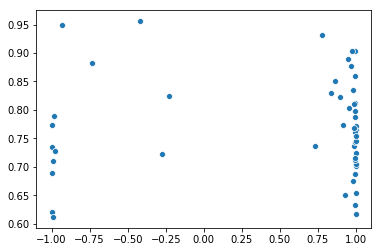

In [111]:
sns.scatterplot(comp, neu)

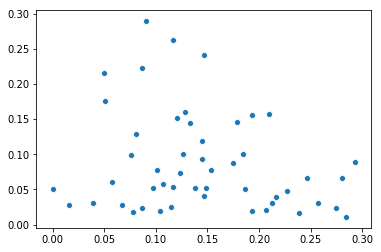

In [109]:
sns.scatterplot(pos, neg)

To start out, we see that compound scores are generally pretty extreme for our songs. And also, positive and negative scores on their own don't seem to show a correlation. We will try to show positive and negative sentiment scores in a different light, showing them in the context of how much of the non-neutral proportion they take up.

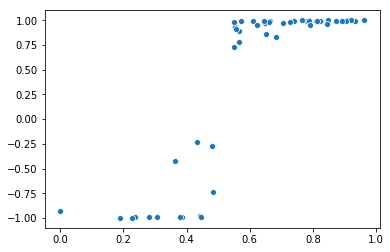

In [113]:
sns.scatterplot(weight_pos, comp)

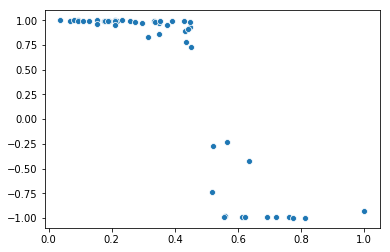

In [114]:
sns.scatterplot(weight_neg, comp)

The two mirrored graphs (we expect them to be mirrored) showcase a similar extreme nature to the compound score, where most of our scores are either very close to 1 or very close to -1. It is interesting to see that a majority of the songs in this playlist are in the upper section, with a very high compound score.

We will try another feature: taking the weighted positive score and subtracting it by the weighted negative score, to see whether a higher positive score will make a difference in relation to two of our audio features: valence and energy.

In [205]:
pos_neg = []

for i in range(len(pos)):
    pos_neg.append(weight_pos[i] - weight_neg[i])

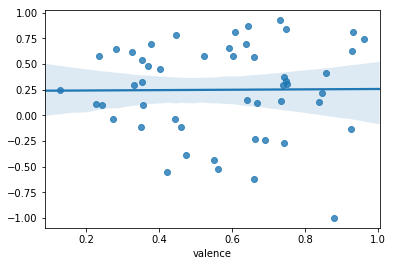

In [212]:
#sns.scatterplot(weight_pos, tens_df["valence"] * tens_df['energy'])
sns.regplot(x=tens_df["valence"], y = pos_neg)

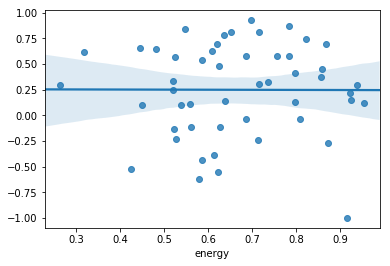

In [204]:
sns.regplot(x=tens_df['energy'], y = pos_neg)

It looks like there doesn't seem to much correlation between valence and our weighted_positive sentiment feature, as well as energy and the weight_positive sentiment feature.

What we will try next is to visualize the comparison between our numeric features, including our features related to sentiment. Some features, such as mode and time signature, don't provide as much potential to show us information. Thus, we will omit them.

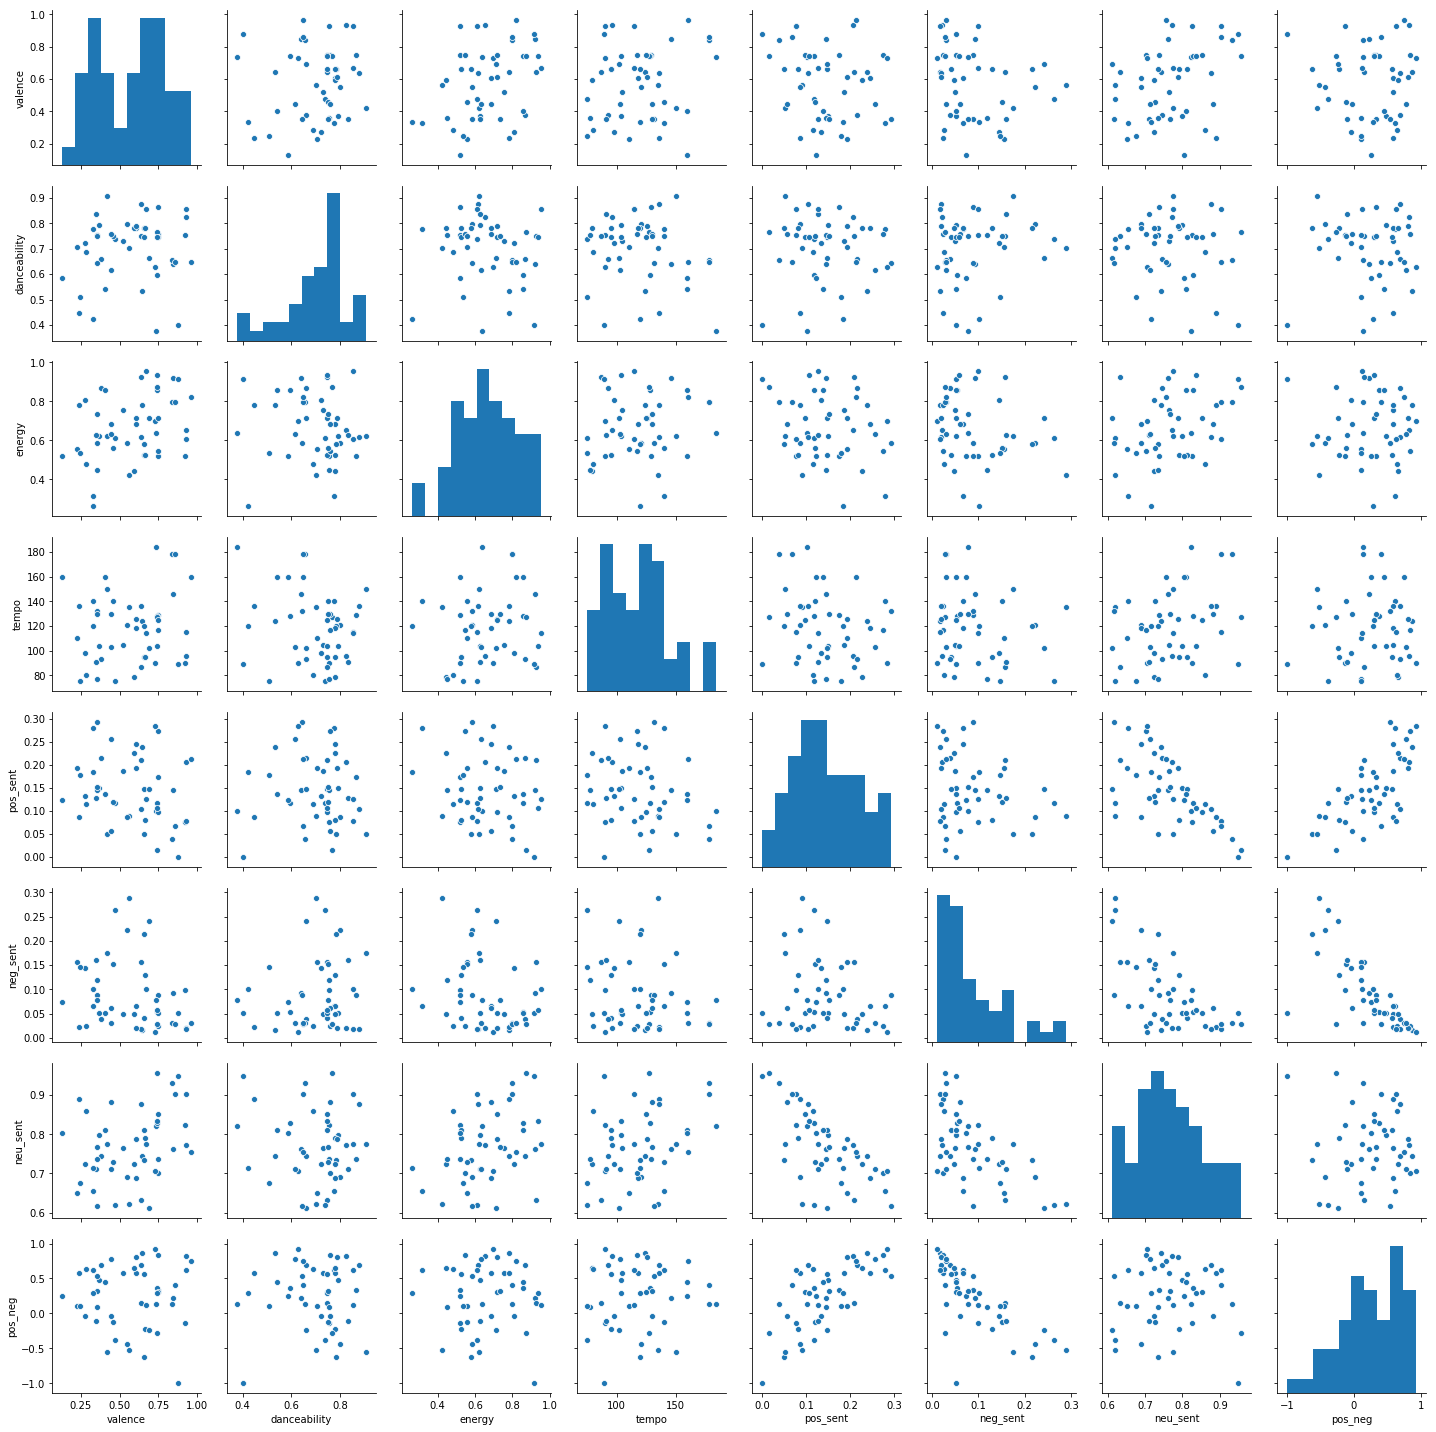

In [217]:
numers = ["valence", 'danceability', 'energy', 'tempo', 
         'pos_sent', 'neg_sent', 'neu_sent', 'pos_neg']
sns.pairplot(tens_df[numers])

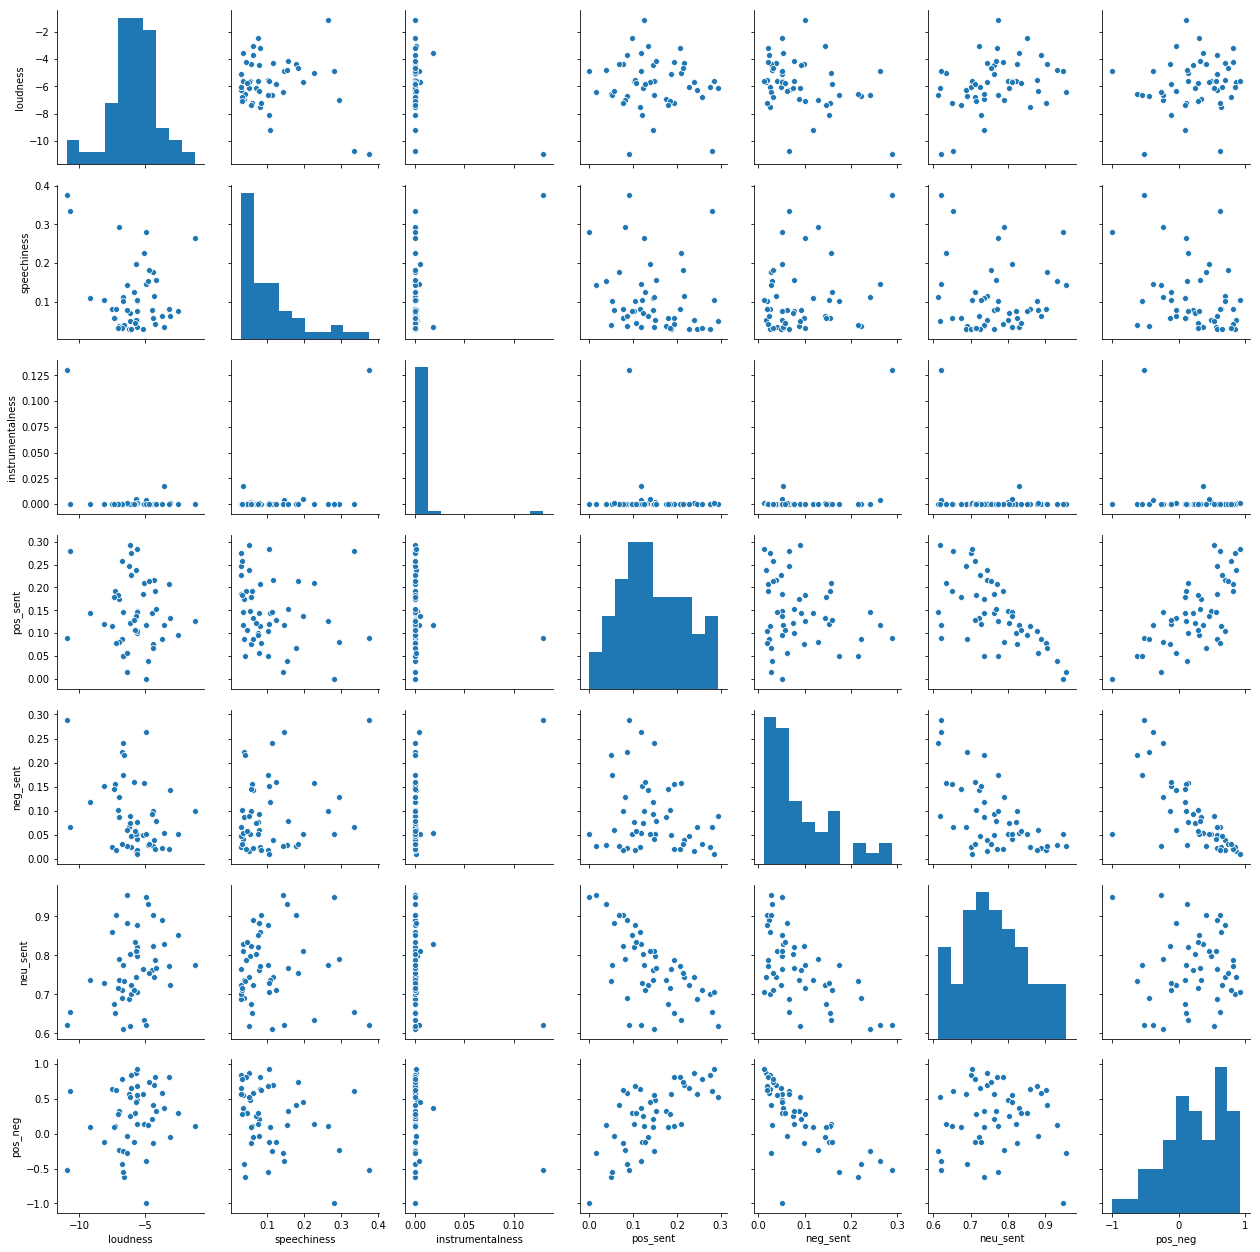

In [218]:
numers_2 = ['loudness', 'speechiness', 'instrumentalness', 
            'pos_sent', 'neg_sent', 'neu_sent', 'pos_neg']
sns.pairplot(tens_df[numers_2])

So from initial analysis, it is difficult to see much linear correlation between the audio features and the sentiment analysis features. It is interesting to see little correlation between the sentiment features and any of the audio features. This could possibly show something about today's relationship between lyrics and music in songs. However, there is much that we will have to look at before we can say that.

Another likely explanation has to do with our data - we chose a "hodgepodge" of songs, without any information about genre. It's very likely that the audio features show information regarding genre, which can then be used to help with our sentiment analysis of lyrics. This will be the next step of our analysis. Also, because of the way our lyrics input is, it is possible that a lack of punctuation and proper breaks may have contributed to the scores in place. 

## Future Ideas for Analysis

In the context of comparing sentiment of lyrics to audio features, there are other avenues that can be taken, which may appear in a future update:

* Take genres and audio features of genres and compare to lyrical sentiment - see if there is a relationship between lyrical sentiment and audio features for genres.
* A deep dive into audio features for specific genres/artists - see if a model can be trained to predict for genre of an artist based on audio features
* Build personal sentiment analyzer and compare to Vader 